# 0. Quick import

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2
# %env CUDA_VISIBLE_DEVICES=1

import os
print(os.getcwd())

# Add Janus package to path
import sys
sys.path.insert(0, "src")

/scratch3/zha439/visionzero
/scratch3/zha439/visionzero


In [2]:
import torch
from PIL import Image
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

Python version is above 3.10, patching the collections module.


/scratch3/zha439/env/r1-v/lib/python3.11/site-packages/transformers/models/auto/image_processing_auto.py:593: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [3]:
def display_alongside_batch(img_list, resize_dims=(512,512)):
    if isinstance(resize_dims, int):
        resize_dims = (resize_dims,resize_dims)
    res = np.concatenate([np.array(img.resize(resize_dims)) for img in img_list], axis=1)
    return Image.fromarray(res)

# 1. Init the model

In [4]:
# specify the device
device = "cuda:1"

# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

# load the model
vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path,
    trust_remote_code=True,
    # attn_implementation="flash_attn_2",
    device_map=device,
    torch_dtype="bfloat16",
)
# vl_gpt = vl_gpt.to(device, torch.bfloat16).eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: num_image_tokens, image_tag, mask_prompt, i

# 2. Understanding

In [ ]:
# gt: 4
question = "How many different items are there in the image?"
image = "src/eval/images/superCLEVR_new_025000.png"

conversation = [
    {
        "role": "<|User|>",
        "content": f"<image_placeholder>\n{question}",
        "images": [image],
    },
    {"role": "<|Assistant|>", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: <image_placeholder>
How many different items are there in the image?

<|Assistant|>: There are four different items in the image.


# 3. Image generation

In [6]:
@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).to(device)
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).to(device)

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state
        
        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]
        
        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    rtn = []
    for i in range(parallel_size):
        rtn.append(Image.fromarray(visual_img[i]))
    return rtn

In [7]:
conversation = [
    {
        "role": "<|User|>",
        "content": "an artistic painting of a sunset over the mountains",
    },
    {"role": "<|Assistant|>", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag

In [8]:
gen_images = generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
    parallel_size=4,
)

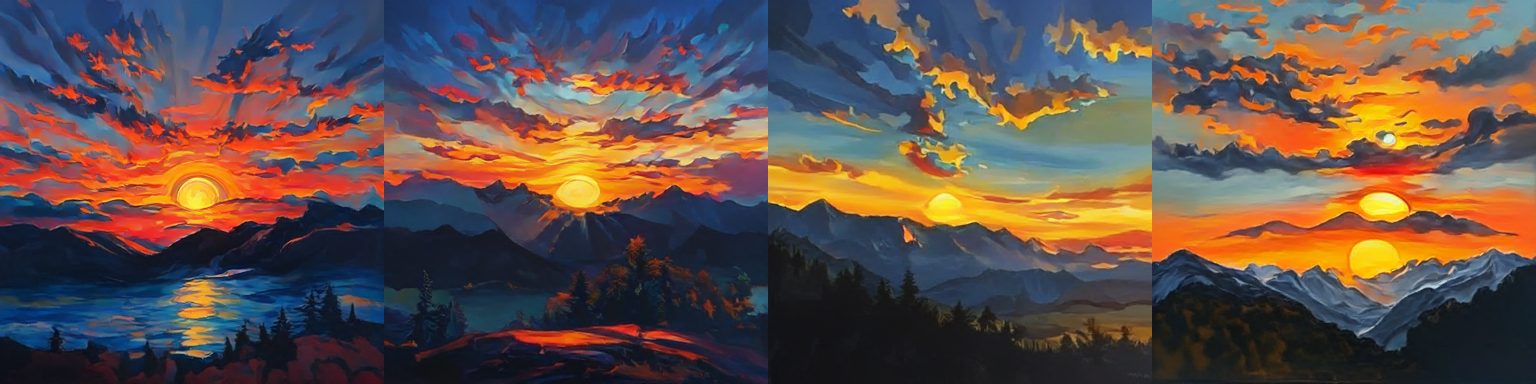

In [10]:
display(display_alongside_batch(gen_images, 384))